
# Clusterização de Pokemóns
# Integrantes:
Alessandra Blücher; 
Bruno Arthur Cesconetto; 
Dennis Zaramelo Felex -
2°C


In [1]:
#importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set() #para gráfico estilizado
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#lendo os dataframes
pokemons = pd.read_json('pokedex.json')
itens = pd.read_json('items.json')
habilidades = pd.read_json('skills.json')
tipos = pd.read_json('types.json')

In [3]:
pokemons.head()

,base,cname,ename,flatName,id,jname,model,skills,type
0,"{'Attack': 49, 'Defense': 49, 'HP': 45, 'Sp.At...",妙蛙种子,Bulbasaur,NaN,1,フシギダネ,NaN,"{'egg': [133, 204, 174, 203, 202, 320, 580, 27...","[草, 毒]"
1,"{'Attack': 62, 'Defense': 63, 'HP': 60, 'Sp.At...",妙蛙草,Ivysaur,NaN,2,フシギソウ,NaN,"{'egg': [133, 204, 174, 203, 202, 320, 580, 27...","[草, 毒]"
2,"{'Attack': 82, 'Defense': 83, 'HP': 80, 'Sp.At...",妙蛙花,Venusaur,NaN,3,フシギバナ,NaN,"{'egg': [133, 204, 174, 203, 202, 320, 580, 27...","[草, 毒]"
3,"{'Attack': 52, 'Defense': 43, 'HP': 39, 'Sp.At...",小火龙,Charmander,NaN,4,ヒトカゲ,NaN,"{'egg': [314, 246, 251, 187, 44, 68, 242, 349,...",[炎]
4,"{'Attack': 64, 'Defense': 58, 'HP': 58, 'Sp.At...",火恐龙,Charmeleon,NaN,5,リザード,NaN,"{'egg': [314, 246, 251, 187, 44, 68, 242, 349,...",[炎]


In [4]:
#abrindo o dicionário contido em pokemons.base e adicionando novas colunas ao dataframe, uma para cada atributo do dicionário: 

#criando listas as quais armazenam os valores de um mesmo atributo
Attack= []
Defense = []
HP = []
SpAtk = []
SpDef = []
Speed = []

#percorrendo o dicionário e adicionando os valores às listas
for idx, row in pokemons['base'].iteritems(): #para cada index i, em cada linha dessa coluna base...
    l=row.keys()   #l é uma variável que contempla as chaves do dicionário

    if 'Attack' in l:   #quando a variável assume a chave ataque
        Attack.append(row['Attack']) #adicionamos seu valor a lista externa "ataque"
    else:
        Attack.append(None) #caso não haja, pass
    if 'Defense' in l:
        Defense.append(row['Defense'])
    else:
        Defense.append(None)
    if 'HP' in l:
        HP.append(row['HP'])
    else:
        HP.append(None)
    if 'Sp.Atk' in l:
        SpAtk.append(row['Sp.Atk'])
    else:
        SpAtk.append(None)
    if 'Sp.Def' in l:
        SpDef.append(row['Sp.Def'])
    else:
        SpDef.append(None) 
    if 'Speed' in l:
        Speed.append(row['Speed'])
    else:
        Speed.append(None)
    
#criando as novas colunas com os valores separados
pokemons['Attack']=Attack
pokemons['Defense']=Defense
pokemons['HP']=HP
pokemons['Sp.Atk']=SpAtk
pokemons['Sp.Def']=SpDef
pokemons['Speed']=Speed


In [5]:
#filtrando o dataframe
df = pokemons[['ename','type','Attack','Defense','HP','Sp.Atk','Sp.Def','Speed']]

#renomenando as colunas
df.columns = ['nome','tipo','ataque','defesa','HP','spe.atk','spe.def','velocidade']

df.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60
2,Venusaur,"[草, 毒]",82,83,80,100,100,80
3,Charmander,[炎],52,43,39,60,50,65
4,Charmeleon,[炎],64,58,58,80,65,80


## Explicação e Exemplos de aplicação de clusters

Referência teórica para diferentes métodos de clusterzação: <br>
http://scikit-learn.org/stable/modules/clustering.html</br>

Exemplos de clusterização por K-means:<br> http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_iris.html</br>
<br>http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html#sphx-glr-auto-examples-cluster-plot-kmeans-digits-py</br>

# Verificando o número ideal de clusters

In [6]:
#guarando os dados em variáveis
v1 = df['ataque']
v2 = df['defesa']
v3 = df['HP']
v4 = df['spe.atk']
v5 = df['spe.def']
v6 = df['velocidade']

#as variáveis serão componentes de uma matriz
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

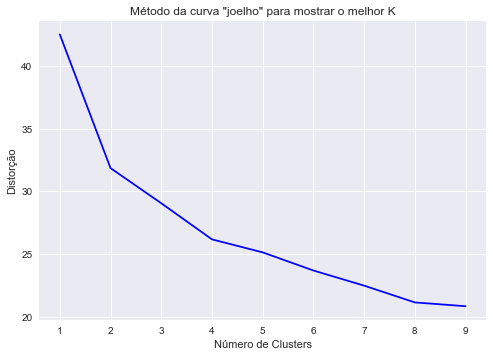

In [7]:
#kmeans determina o k ideal
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

#plotando 
plt.plot(K, distortions, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Distorção')
plt.title('Método da curva "joelho" para mostrar o melhor K')
plt.show()
 

# Clusterizando o Dataframe

In [8]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
df.loc[:,'cluster'] = kmeans.labels_ #indentificando cada um dos pokemóns por seu cluster numa nova coluna para futura análise
df.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45,1
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60,1
2,Venusaur,"[草, 毒]",82,83,80,100,100,80,0
3,Charmander,[炎],52,43,39,60,50,65,1
4,Charmeleon,[炎],64,58,58,80,65,80,1


# Plotando o resultado do fit realizado pelo Kmeans 

In [9]:
#função que plota o gráfico com os clusters
def showcluster(info, k, color, titulo):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(titulo)
    ax.set_xlabel(str(info[0].name))
    ax.set_ylabel(str(info[1].name))
    ax.set_zlabel(str(info[2].name))
    if k!=len(color):
        print ("numero de cores diferente de clusters", len(color),k)
        return 0
    for i in range(0,k):
        ax.scatter(info[0][df.cluster==i], info[1][df.cluster==i], info[2][df.cluster==i], marker='o', c=color[i])
    return fig

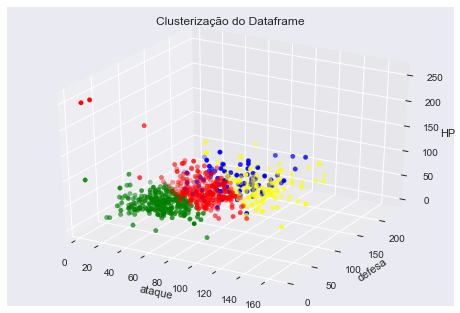

In [10]:
showcluster([df.ataque,df.defesa,df.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização do Dataframe')

# Filtrando o dataframe por clusters

In [11]:
cluster1 = df[df.cluster==0]
cluster1.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
2,Venusaur,"[草, 毒]",82,83,80,100,100,80,0
5,Charizard,"[炎, 飞行]",84,78,78,109,85,100,0
7,Wartortle,[水],63,80,59,65,80,58,0
14,Beedrill,"[虫, 毒]",90,40,65,45,80,75,0
17,Pidgeot,"[一般, 飞行]",80,75,83,70,70,101,0


In [12]:
cluster2 = df[df.cluster==1]
cluster2.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45,1
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60,1
3,Charmander,[炎],52,43,39,60,50,65,1
4,Charmeleon,[炎],64,58,58,80,65,80,1
6,Squirtle,[水],48,65,44,50,64,43,1


In [13]:
cluster3 = df[df.cluster==2]
cluster3.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
8,Blastoise,[水],83,100,79,85,105,78,2
27,Sandslash,[地上],100,110,75,45,55,65,2
73,Geodude,"[岩石, 地上]",80,100,40,30,30,20,2
74,Graveler,"[岩石, 地上]",95,115,55,45,45,35,2
75,Golem,"[岩石, 地上]",120,130,80,55,65,45,2


In [14]:
cluster4 = df[df.cluster==3]
cluster4.head()

,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
30,Nidoqueen,"[毒, 地上]",92,87,90,75,85,76,3
33,Nidoking,"[毒, 地上]",102,77,81,85,75,85,3
58,Arcanine,[炎],110,80,90,100,80,95,3
61,Poliwrath,"[水, 格斗]",95,95,90,70,90,70,3
67,Machamp,[格斗],130,80,90,65,85,55,3


# Análise de sensibilidade<br>
Como delimitar uma váriavel como parâmetro para a análise das outras duas pode resultar em distribuições diferentes, dependendo da variável delimitada, será realizada a análise dos 3 casos separadamente: </br>

### Para dado poder de ataque, como as outras duas variáveis interferem na distribuição?

In [15]:
#ataques baixos
ataque40 = df[df.ataque<=40]

#repetindo o processo da clusterização do dataframe completo
v1 = ataque40['ataque']
v2 = ataque40['defesa']
v3 = ataque40['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [16]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
ataque40.loc[:,'cluster'] = kmeans.labels_
ataque40.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
9,Caterpie,[虫],30,35,45,20,20,45,0
10,Metapod,[虫],20,55,50,25,25,30,3
12,Weedle,"[虫, 毒]",35,30,40,20,20,50,0
13,Kakuna,"[虫, 毒]",25,50,45,25,25,35,3
62,Abra,[超能],20,15,25,105,55,90,0


In [17]:
#ataques médios
ataque80 = df[(df['ataque']>40) & (df['ataque'] <= 80)]
#repetindo o processo da clusterização do dataframe completo
v1 = ataque80['ataque']
v2 = ataque80['defesa']
v3 = ataque80['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [18]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
ataque80.loc[:,'cluster'] = kmeans.labels_
ataque80.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45,1
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60,3
3,Charmander,[炎],52,43,39,60,50,65,1
4,Charmeleon,[炎],64,58,58,80,65,80,3
6,Squirtle,[水],48,65,44,50,64,43,1


In [19]:
#ataques fortes
ataquef = df[df['ataque'] > 80]
#repetindo o processo da clusterização do dataframe completo
v1 = ataquef['ataque']
v2 = ataquef['defesa']
v3 = ataquef['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [20]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
ataquef.loc[:,'cluster'] = kmeans.labels_
ataquef.head()


C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
2,Venusaur,"[草, 毒]",82,83,80,100,100,80,0
5,Charizard,"[炎, 飞行]",84,78,78,109,85,100,0
8,Blastoise,[水],83,100,79,85,105,78,0
14,Beedrill,"[虫, 毒]",90,40,65,45,80,75,1
19,Raticate,[一般],81,60,55,50,70,97,1


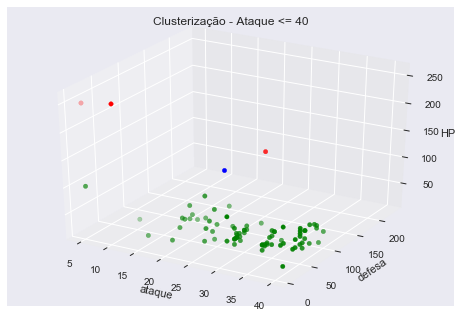

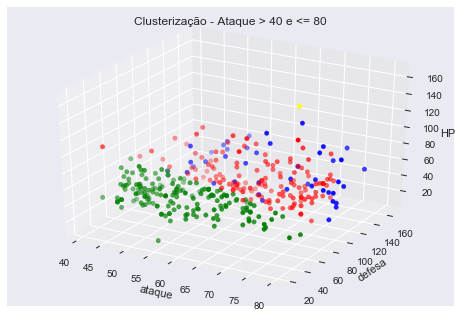

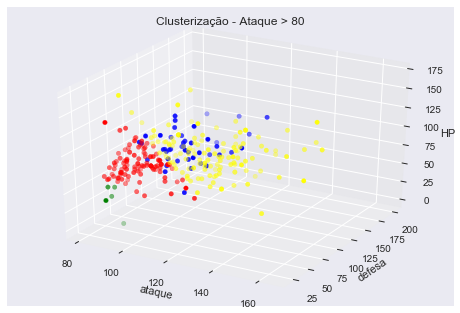

In [45]:
#área de plotagem
fig = plt.figure(figsize=plt.figaspect(0.5))

plot = showcluster([ataque40.ataque,ataque40.defesa,ataque40.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - Ataque <= 40')

plot = showcluster([ataque80.ataque,ataque80.defesa,ataque80.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - Ataque > 40 e <= 80')

plot = showcluster([ataquef.ataque,ataquef.defesa,ataquef.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - Ataque > 80')

plt.show()


### Separando os dataframes de ataque por clusters

In [22]:
#ataques fracos
a400 = ataque40[ataque40.cluster==0]
a401 = ataque40[ataque40.cluster==1]
a402 = ataque40[ataque40.cluster==2]
a403 = ataque40[ataque40.cluster==3]

In [23]:
#ataques médios
a800 = ataque80[ataque80.cluster==0]
a801 = ataque80[ataque80.cluster==1]
a802 = ataque80[ataque80.cluster==2]
a803 = ataque80[ataque80.cluster==3]

In [24]:
#ataques fortes
af0 = ataquef[ataquef.cluster==0]
af1 = ataquef[ataquef.cluster==1]
af2 = ataquef[ataquef.cluster==2]
af3 = ataquef[ataquef.cluster==3]

### Para dada capacidade de defesa, como as outras duas variáveis interferem na distribuição?

In [25]:
#defesas baixas
defesa40 = df[df.defesa<=40]

#repetindo o processo da clusterização do dataframe completo
v1 = defesa40['ataque']
v2 = defesa40['defesa']
v3 = defesa40['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [26]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesa40.loc[:,'cluster'] = kmeans.labels_
defesa40.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
9,Caterpie,[虫],30,35,45,20,20,45,3
12,Weedle,"[虫, 毒]",35,30,40,20,20,50,3
14,Beedrill,"[虫, 毒]",90,40,65,45,80,75,0
15,Pidgey,"[一般, 飞行]",45,40,40,35,35,56,3
18,Rattata,[一般],56,35,30,25,35,72,3


In [27]:
#defesas médias
defesa80 = df[(df['defesa']>40) & (df['defesa'] <= 80)]
#repetindo o processo da clusterização do dataframe completo
v1 = defesa80['ataque']
v2 = defesa80['defesa']
v3 = defesa80['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [28]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesa80.loc[:,'cluster'] = kmeans.labels_
defesa80.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45,2
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60,0
3,Charmander,[炎],52,43,39,60,50,65,2
4,Charmeleon,[炎],64,58,58,80,65,80,0
5,Charizard,"[炎, 飞行]",84,78,78,109,85,100,0


In [29]:
#defesas fortes
defesaf = df[df['defesa'] > 80]
#repetindo o processo da clusterização do dataframe completo
v1 = defesaf['ataque']
v2 = defesaf['defesa']
v3 = defesaf['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [30]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
defesaf.loc[:,'cluster'] = kmeans.labels_
defesaf.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
2,Venusaur,"[草, 毒]",82,83,80,100,100,80,2
8,Blastoise,[水],83,100,79,85,105,78,2
26,Sandshrew,[地上],75,85,50,20,30,40,1
27,Sandslash,[地上],100,110,75,45,55,65,2
30,Nidoqueen,"[毒, 地上]",92,87,90,75,85,76,2


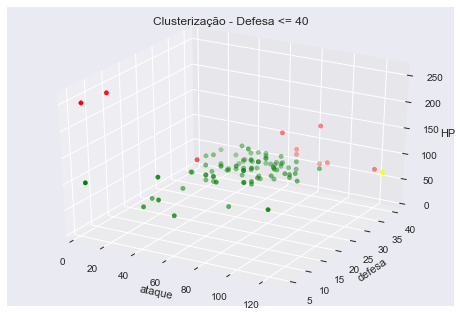

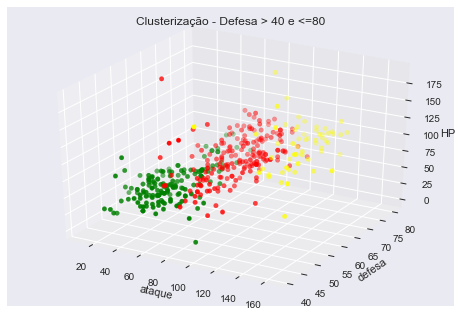

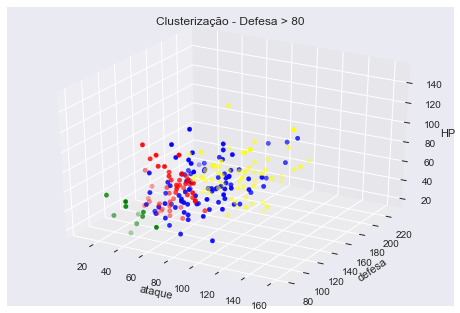

In [31]:
#área de plotagem
fig = plt.figure(figsize=plt.figaspect(0.5))

plot = showcluster([defesa40.ataque,defesa40.defesa,defesa40.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - Defesa <= 40')

plot = showcluster([defesa80.ataque,defesa80.defesa,defesa80.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - Defesa > 40 e <=80')

plot = showcluster([defesaf.ataque,defesaf.defesa,defesaf.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - Defesa > 80')

plt.show()

### Separando os dataframes de defesa por clusters

In [32]:
#defesas fracas
d400 = defesa40[defesa40.cluster==0]
d401 = defesa40[defesa40.cluster==1]
d402 = defesa40[defesa40.cluster==2]
d403 = defesa40[defesa40.cluster==3]

In [33]:
#defesas médias
d800 = defesa80[defesa80.cluster==0]
d801 = defesa80[defesa80.cluster==1]
d802 = defesa80[defesa80.cluster==2]
d803 = defesa80[defesa80.cluster==3]

In [34]:
#defesas fortes
df0 = defesaf[defesaf.cluster==0]
df1 = defesaf[defesaf.cluster==1]
df2 = defesaf[defesaf.cluster==2]
df3 = defesaf[defesaf.cluster==3]

   ### Para dado nível de HP, como as outras duas variáveis interferem na distribuição?

In [35]:
#HP baixo
HP40 = df[df.HP<=40]

#repetindo o processo da clusterização do dataframe completo
v1 = HP40['ataque']
v2 = HP40['defesa']
v3 = HP40['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [36]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HP40.loc[:,'cluster'] = kmeans.labels_
HP40.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
3,Charmander,[炎],52,43,39,60,50,65,2
12,Weedle,"[虫, 毒]",35,30,40,20,20,50,0
15,Pidgey,"[一般, 飞行]",45,40,40,35,35,56,0
18,Rattata,[一般],56,35,30,25,35,72,2
20,Spearow,"[一般, 飞行]",60,30,40,31,31,70,2


In [37]:
#HP médio
HP80 = df[(df['HP']>40) & (df['HP'] <= 80)]
#repetindo o processo da clusterização do dataframe completo
v1 = HP80['ataque']
v2 = HP80['defesa']
v3 = HP80['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [38]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HP80.loc[:,'cluster'] = kmeans.labels_
HP80.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
0,Bulbasaur,"[草, 毒]",49,49,45,65,65,45,1
1,Ivysaur,"[草, 毒]",62,63,60,80,80,60,3
2,Venusaur,"[草, 毒]",82,83,80,100,100,80,3
4,Charmeleon,[炎],64,58,58,80,65,80,1
5,Charizard,"[炎, 飞行]",84,78,78,109,85,100,3


In [39]:
#HP alto
HPa = df[df['HP'] > 80]
#repetindo o processo da clusterização do dataframe completo
v1 = HPa['ataque']
v2 = HPa['defesa']
v3 = HPa['HP']
X=np.array(list(zip(v1,v2,v3))).reshape(len(v1),3)

In [40]:
kmeans = KMeans(n_clusters=4).fit(X)
y_kmeans = kmeans.predict(X)
HPa.loc[:,'cluster'] = kmeans.labels_
HPa.head()

C:\Users\denni\Anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,nome,tipo,ataque,defesa,HP,spe.atk,spe.def,velocidade,cluster
17,Pidgeot,"[一般, 飞行]",80,75,83,70,70,101,0
30,Nidoqueen,"[毒, 地上]",92,87,90,75,85,76,0
33,Nidoking,"[毒, 地上]",102,77,81,85,75,85,0
35,Clefable,[妖精],70,73,95,95,90,60,0
38,Jigglypuff,"[一般, 妖精]",45,20,115,45,25,20,2


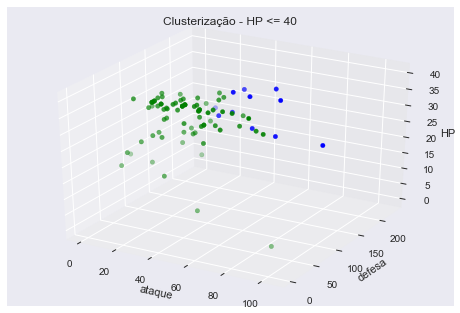

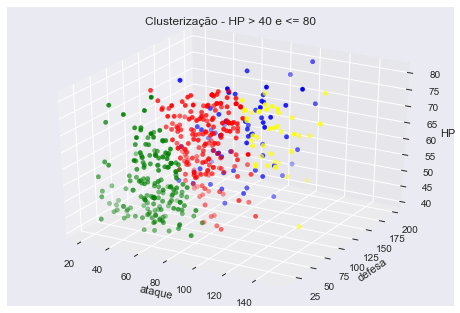

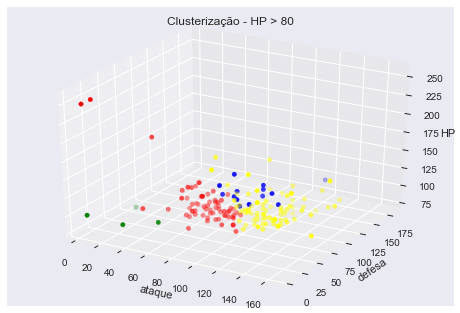

In [41]:
#área de plotagem
fig = plt.figure(figsize=plt.figaspect(0.5))

plot = showcluster([HP40.ataque,HP40.defesa,HP40.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - HP <= 40')

plot = showcluster([HP80.ataque,HP80.defesa,HP80.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - HP > 40 e <= 80')

plot = showcluster([HPa.ataque,HPa.defesa,HPa.HP],4,[['red'],['green'],['blue'],['yellow']], 'Clusterização - HP > 80')

plt.show()

### Separando os dataframes de HP por clusters

In [42]:
#HP Baixo
hp400 = HP40[HP40.cluster==0]
hp401 = HP40[HP40.cluster==1]
hp402 = HP40[HP40.cluster==2]
hp403 = HP40[HP40.cluster==3]

In [43]:
#HP Médio
hp800 = HP80[HP80.cluster==0]
hp801 = HP80[HP80.cluster==1]
hp802 = HP80[HP80.cluster==2]
hp803 = HP80[HP80.cluster==3]

In [44]:
#HP Alto
hpa0 = HPa[HPa.cluster==0]
hpa1 = HPa[HPa.cluster==1]
hpa2 = HPa[HPa.cluster==2]
hpa3 = HPa[HPa.cluster==3]